In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


#### Experiment #1 : HandCrafted AntiSymmetric Bipolar Convolution


In [2]:
k = 20 # Top 10% highest l2-magnitude filters

In [3]:
F = 0

filters = np.zeros((3,3,1,1))

t = np.zeros((3,3))
t[1, 0] = 0.75
t[0, 0] = 0.25
filters = np.reshape(fft.idctn(t, norm='ortho'), (3,3,1,1)) 
filters /= np.sum(np.abs(filters))

#filters[:,:,0,0] =  (1/9)*np.array([[1,1,1], [1,1,1], [1,1,1]]) + (1/6)*np.array([[1,1,1], [0,0,0], [-1,-1,-1]]) 


theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)

a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])
mag = reduce_euclidean_norm(filters, axis=[0,1])


x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y =( a_mag[:,F]*np.sin((theta[:,F]))).numpy()
z =(s_mag[:,F]*np.sign(np.mean(s, axis=(0,1)))[:,F]).numpy()
plt.rcParams.update({'figure.dpi': '100'})




(3, 3, 1, 1)
(1, 3, 3, 1) (1, 3, 3, 1) (1, 3, 3, 1)


In [4]:
#var = 2/(128*9)

img =  cv2.imread('input4.png', 0)/255. 
#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)

(224, 224)


In [5]:
np.var(img), 1/(128*9)


(0.023040123255935026, 0.0008680555555555555)

(3, 3, 1, 1)
0
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(0.0, shape=(), dtype=float32) 11.015031
(1, 224, 224, 1)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(6.081163, shape=(), dtype=float32) 16.998823
(1, 224, 224, 1)
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(6.5156384, shape=(), dtype=float32) 16.951483
(1, 224, 224, 1)
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(6.6821012, shape=(), dtype=float32) 16.88855
(1, 224, 224, 1)
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(6.741299, shape=(), dtype=float32) 16.780396
(1, 224, 224, 1)
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


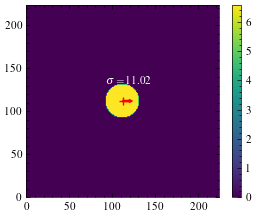

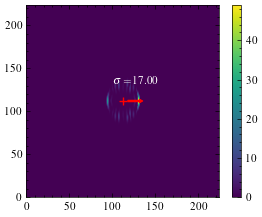

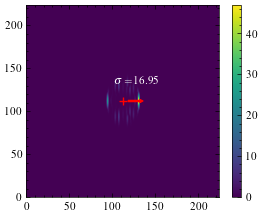

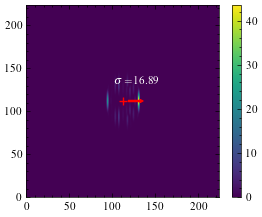

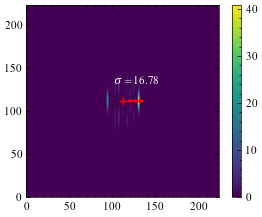

In [6]:
import matplotlib.patches as mpatches

w =tf.cast(filters, dtype=tf.float32)# tf.expand_dims(filters, -1), dtype=tf.float32)
w = tf.transpose(w, perm=(1,0,2,3))
print(w.shape)

x = img


directory = f"figures/hand_0.75_bipolar(flipping)"
if not os.path.exists(directory):
	os.makedirs(directory)
x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 
for i in range(100):
	print(i)
	if i in [0, 19, 39, 59, 79]:

		fig, ax = plt.subplots()
		print(x.shape)
		
		x = x/np.std(x)
		vals = x[0, x.shape[1]//2, :, :]
		vals = vals/np.sum(vals)

		print("VALS", np.sum(vals))
		pos = np.expand_dims(np.linspace(-x.shape[1]//2, x.shape[1]//2, x.shape[1]),-1)
		mean = tf.reduce_sum(pos*vals)
		var = tf.reduce_sum(((pos-mean)**2) * vals)
		std = np.sqrt(var)
		print(mean, np.sqrt(var))
		
		#x = tf.repeat(x , repeats = filters.shape[-2], axis=-1)
		print(x.shape)

		im = ax.imshow(np.sum(x[0,:,:,:], axis=-1))
		ax.plot(112, 112, marker = '+', color='red')

		#ax.plot(112+mean, 112, marker = ".", color='black')
		arr =  mpatches.FancyArrowPatch((112.+mean, 112.), (112+mean+std, 112),
								mutation_scale=4, shrinkA=0, shrinkB=0,zorder=10, color="red")
		ax.add_patch(arr)
		
		ax.annotate(r'$\sigma=$'+f"{std:.2f}", (.5, 6), xycoords=arr, ha='center', va='bottom',color='white')
		#ax.arrow(, 112, dx=, dy= 0, color='black')

		ax.set(xlim=(0, 224), ylim=(0, 224))

		fig.colorbar(im, orientation='vertical')
		fig.savefig(directory + f'/{i}.pdf', dpi=600,  transparent=True, bbox_inches='tight')

	x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							padding='SAME') )
	w = np.rot90(w, k=2, axes=(0,1))


(0.0, 224.0)

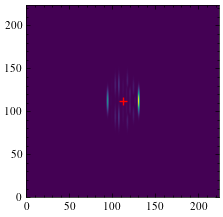

In [7]:
x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
						padding='SAME') )
	
im = plt.imshow(np.sum(x[0,:,:,:], axis=-1))
plt.plot(112, 112, marker = '+', color='red')
plt.xlim([0, 224])#, ylim=(0, 224))
plt.ylim([0, 224])#, ylim=(0, 224))

#, ylim=(0, 224))

In [8]:
pos[:, x.shape[1]//2, : , :]

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

In [ ]:
pos

array([-112.        , -110.9955157 , -109.99103139, -108.98654709,
       -107.98206278, -106.97757848, -105.97309417, -104.96860987,
       -103.96412556, -102.95964126, -101.95515695, -100.95067265,
        -99.94618834,  -98.94170404,  -97.93721973,  -96.93273543,
        -95.92825112,  -94.92376682,  -93.91928251,  -92.91479821,
        -91.9103139 ,  -90.9058296 ,  -89.90134529,  -88.89686099,
        -87.89237668,  -86.88789238,  -85.88340807,  -84.87892377,
        -83.87443946,  -82.86995516,  -81.86547085,  -80.86098655,
        -79.85650224,  -78.85201794,  -77.84753363,  -76.84304933,
        -75.83856502,  -74.83408072,  -73.82959641,  -72.82511211,
        -71.8206278 ,  -70.8161435 ,  -69.81165919,  -68.80717489,
        -67.80269058,  -66.79820628,  -65.79372197,  -64.78923767,
        -63.78475336,  -62.78026906,  -61.77578475,  -60.77130045,
        -59.76681614,  -58.76233184,  -57.75784753,  -56.75336323,
        -55.74887892,  -54.74439462,  -53.73991031,  -52.73542

In [ ]:
pos[x.shape[1]//2]

0.5022421524663656